C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


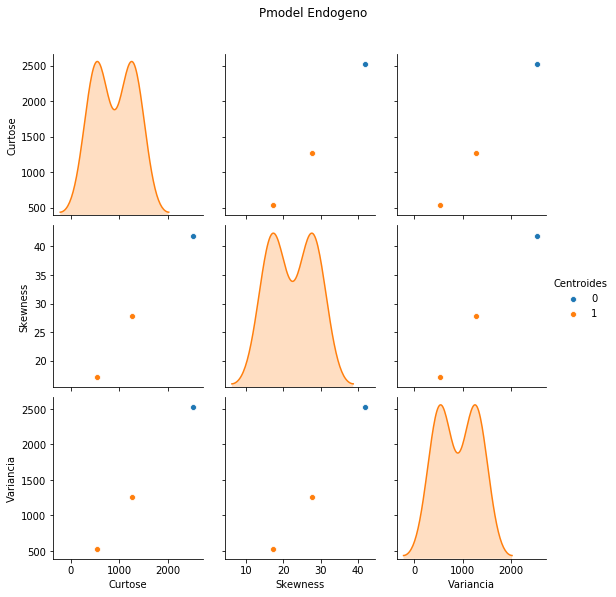

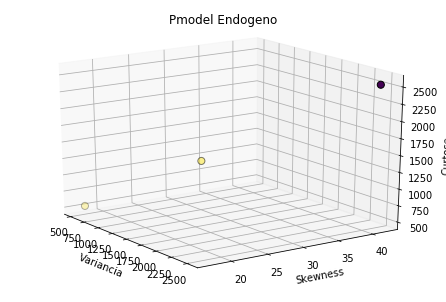

C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\yurid\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


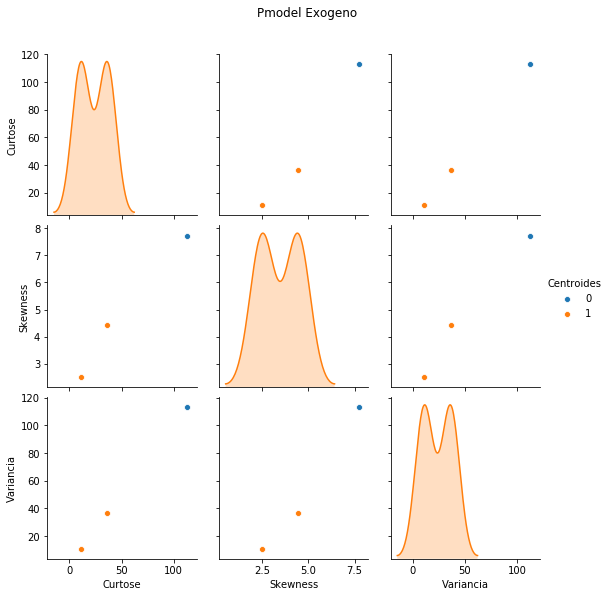

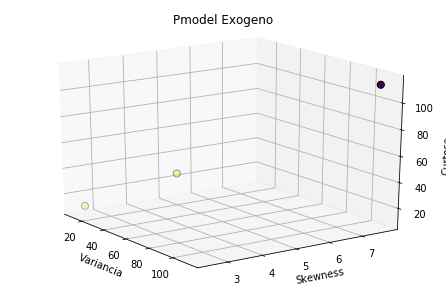

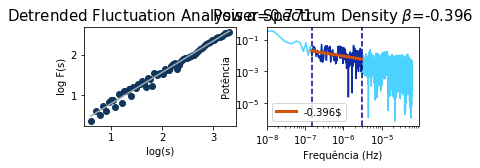

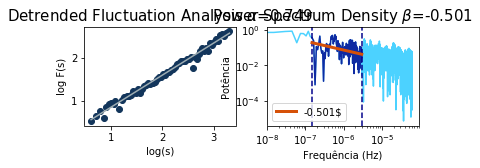

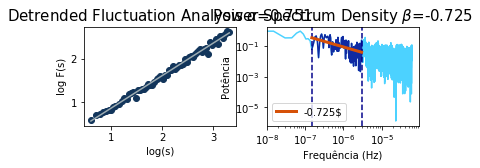

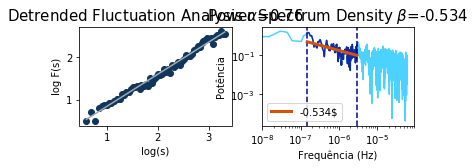

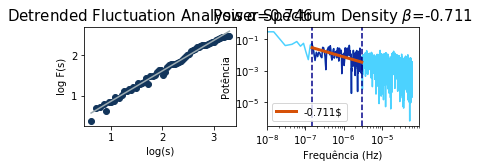

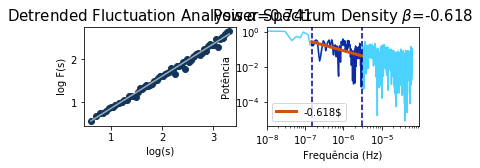

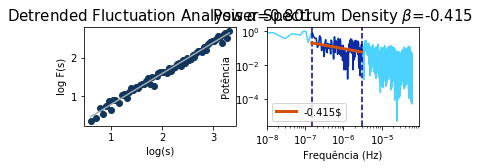

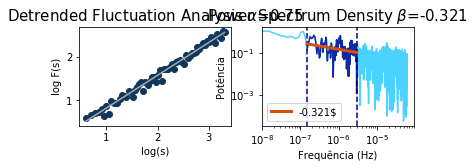

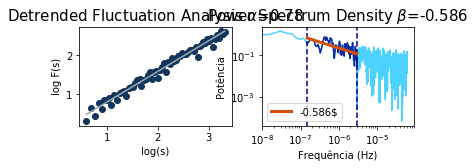

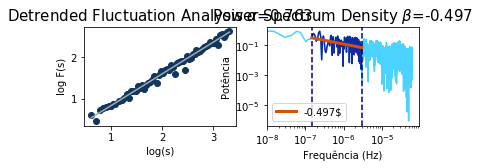

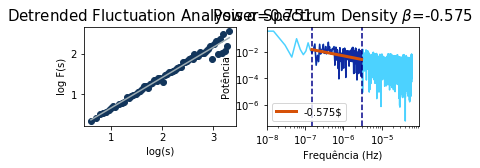

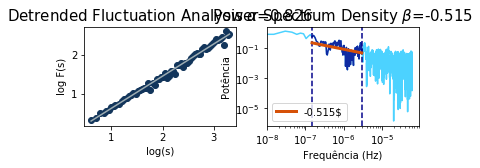

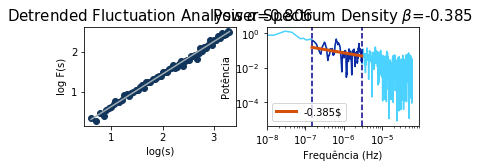

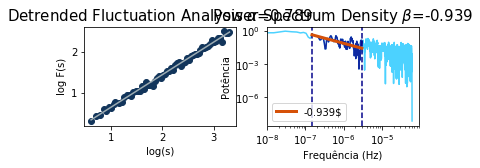

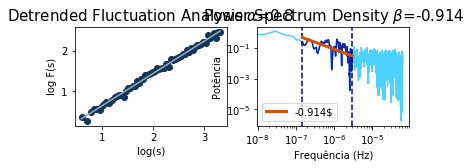

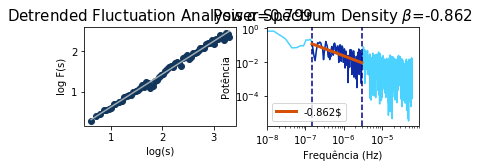

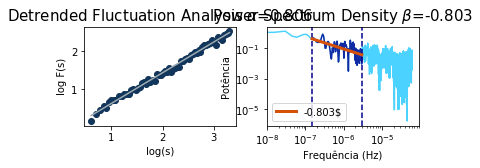

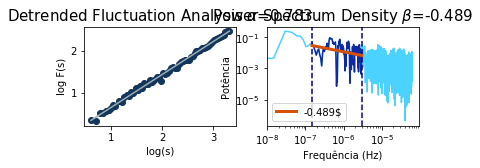

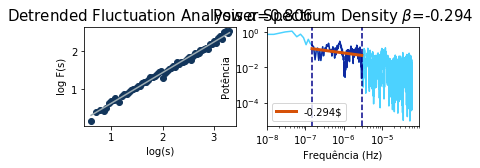

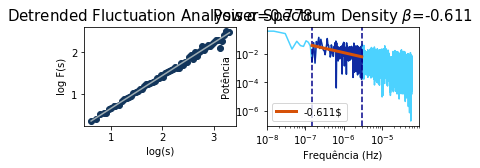

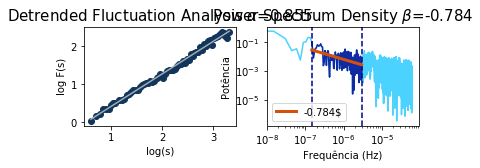

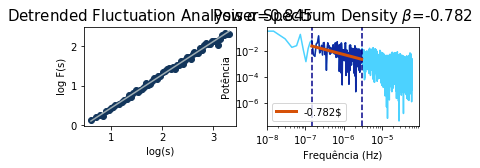

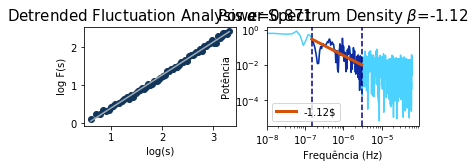

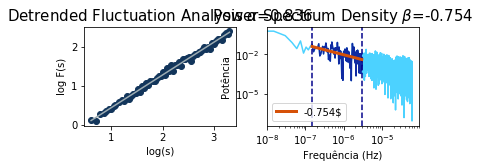

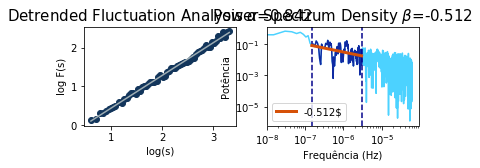

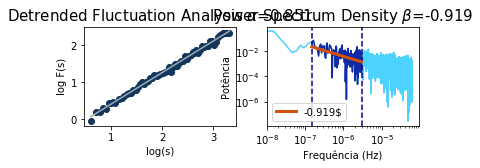

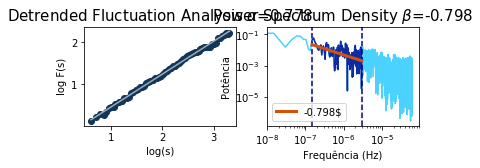

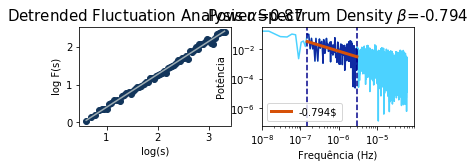

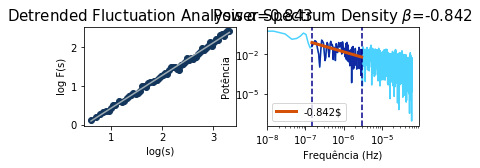

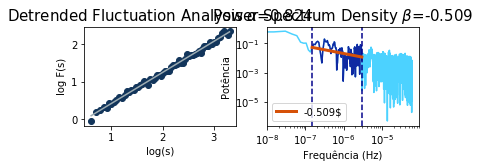

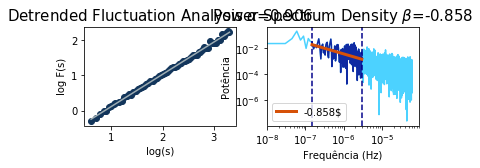

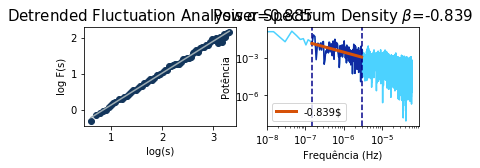

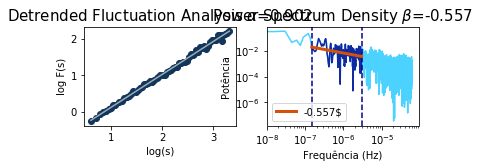

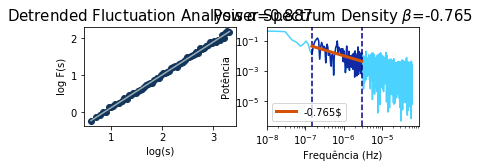

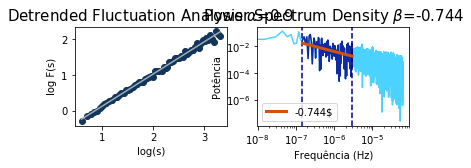

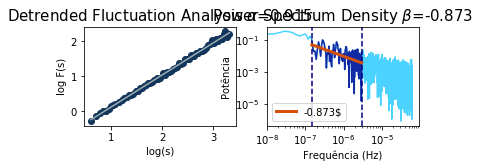

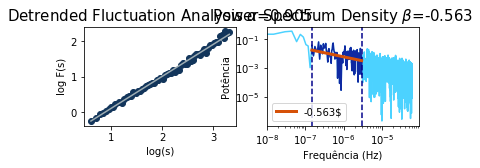

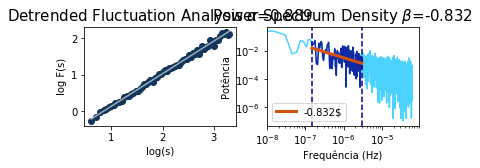

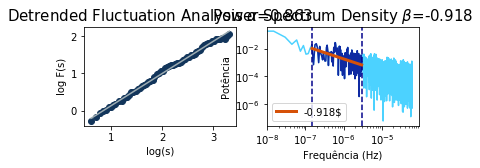

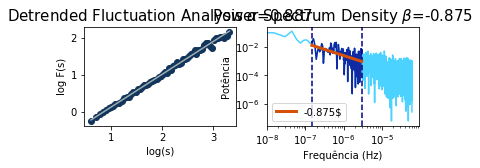

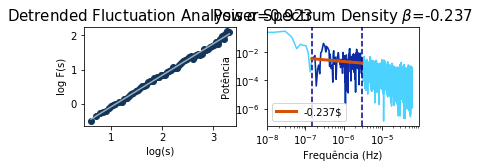

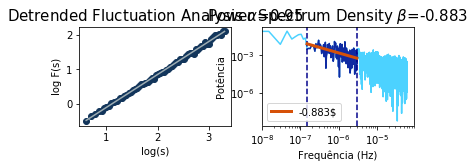

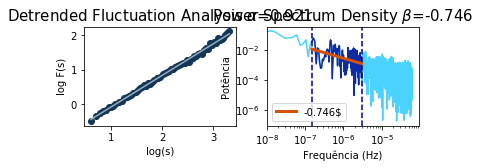

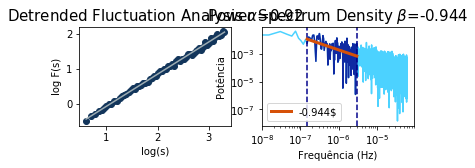

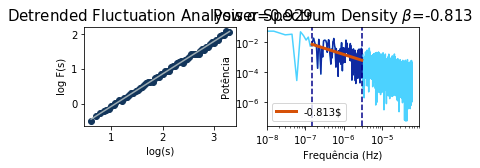

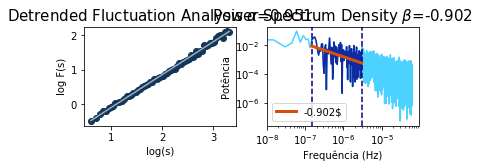

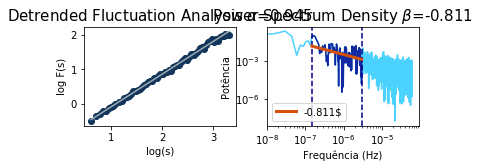

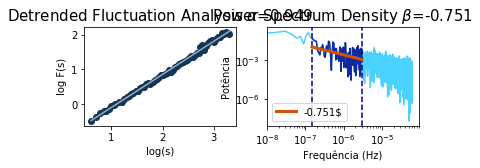

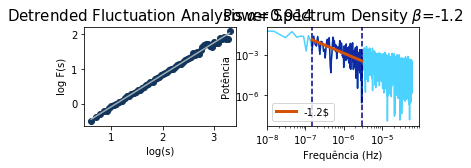

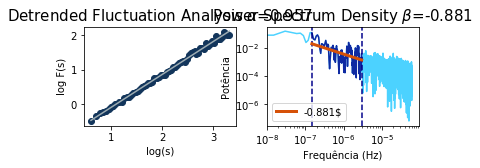

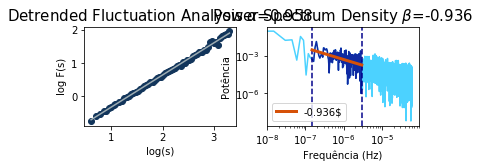

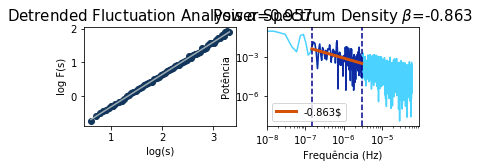

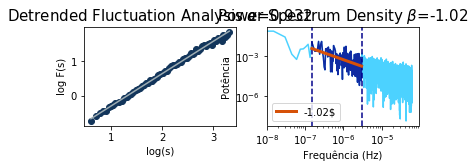

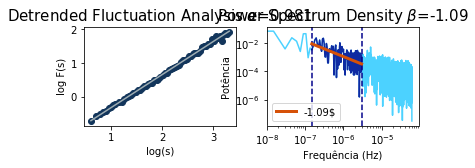

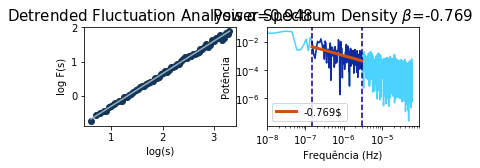

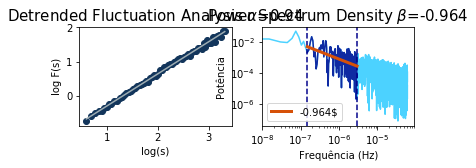

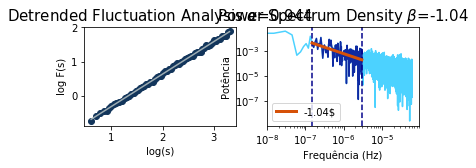

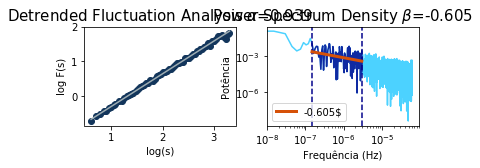

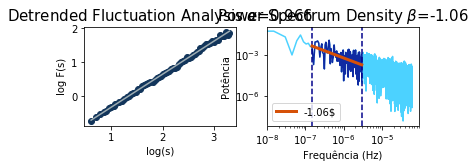

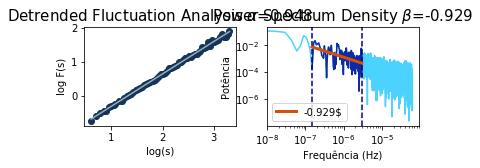

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import scipy.stats
import seaborn as sb
import statsfuncs
import mfdfa

n = 8192
res = n / 12
i = 0
j = 0
df = []
dy = []


def pmodel(noValues=8192, p=0.049, slope=[]):
    noOrders = int(np.ceil(np.log2(noValues)))
    noValuesGenerated = 2**noOrders
        
    y = np.array([1])
    for n in range(noOrders):
        y = next_step_1d(y, p)
    
    if (slope):
        fourierCoeff = fractal_spectrum_1d(noValues, slope/2)
        meanVal = np.mean(y)
        stdy = np.std(y)
        x = np.fft.ifft(y - meanVal)
        phase = np.angle(x)
        x = fourierCoeff*np.exp(1j*phase)
        x = np.fft.fft(x).real
        x *= stdy/np.std(x)
        x += meanVal 
    else:
        x = y
    
    return x[0:noValues], y[0:noValues]

     
def next_step_1d(y, p):
    y2 = np.zeros(y.size*2)
    sign = np.random.rand(1, y.size) - 0.5
    sign /= np.abs(sign)
    y2[0:2*y.size:2] = y + sign*(1-2*p)*y
    y2[1:2*y.size+1:2] = y - sign*(1-2*p)*y
    
    return y2


def fractal_spectrum_1d(noValues, slope):
    ori_vector_size = noValues
    ori_half_size = ori_vector_size//2
    a = np.zeros(ori_vector_size)
    
    for t2 in range(ori_half_size):
        index = t2
        t4 = 1 + ori_vector_size - t2
        if (t4 >= ori_vector_size):
            t4 = t2
        coeff = (index + 1)**slope
        a[t2] = coeff
        a[t4] = coeff
        
    a[1] = 0
    
    return a

def calcPmodel(n, p, beta, modelo):
    for i in range(3):
        for j in range(10):

            x, y = pmodel(n, p, beta)

            #Normaliza os dados gerados randomincamente
            y=y-1

            df.append(pd.DataFrame(x, columns=['Serie ' + str(j + 1)]))
            dy.append(pd.DataFrame(y, columns=['Serie ' + str(j + 1)]))

            #Salva os gráficos do p-model 
            plt.plot(dy[j])
            plt.title(modelo + " Series")
            plt.ylabel("Valores de Amplitude")
            plt.xlabel("N passos no tempo")
            plt.savefig('Representacoes/'+modelo+'/Familia' + modelo + '_Faixa' + str(p) + ' - Serie '+ str(j+1) +'.png')
            plt.show()
            plt.close()

            #Gerando Histograma dos p-model normalizado
            df[j].hist(column='Serie ' + str(j+1), bins=int(n/10), ec="k", alpha=0.6, color='royalblue')
            plt.savefig('Histogramas_Normalizados/'+modelo+'/Familia' + modelo + '_Faixa' + str(p) + ' - Serie '+ str(j+1) + '.png')
            plt.show()
            plt.close()
    
        #Concatena as series da familia gerada randomicamente, como também as normalizadas
        a = pd.concat([df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9]], axis=1, join='inner')
        b = pd.concat([dy[0], dy[1], dy[2], dy[3], dy[4], dy[5], dy[6], dy[7], dy[8], dy[9]], axis=1, join='inner')

        # Armazena as series concatenadas em arquivo .csv
        a.to_csv('Arquivos/'+modelo+'/familia' + modelo + '_Faixa' + str(p) + 'X.csv', index=False, header=True)
        b.to_csv('Arquivos/'+modelo+'/Series Normalizadas/familia' + modelo + '_Faixa' + str(p) + 'Y.csv', index=False, header=True)
        j = 0
        df.clear()
        dy.clear()
        p = p + 0.04

def calcMomentosEstocasticos(modelo, p):
    
    #Para gerar os momentos estocasticos dos p-models endogenos, é necessário pegar apenas uma serie 
    #e calcular, para cada familia, os quatro momentos.Pega-se só uma serie como amostra,
    #pois todas as series ao serem calculados cada um dos momentos retornam o mesmo valor para cada momento.
    
    i = 0
    curt = []
    skew = []
    var = []
    media = []
    
    for i in range(3):
        dado = pd.read_csv('Arquivos/' +modelo+'/Series Normalizadas/familia' + modelo + '_Faixa' + str(p) + 'Y.csv') 
        amostra = dado['Serie 1']
        
        #Gera as Skewness dos p-models endogenos normalizados e armazena-as em arquivos .csv
        amostraSkew = pd.DataFrame(pd.DataFrame(amostra).skew(axis=0, skipna=True), columns=['Skewness'])
        skew.append(amostraSkew)
        
        #Gera as Curtosis dos p-models endogenos normalizados e armazena-as em arquivos .csv
        amostraCurt = pd.DataFrame(pd.DataFrame(amostra).kurtosis(axis=0, skipna=True), columns=['Curtose'])
        curt.append(amostraCurt)
        
        #Gera as Media dos p-models endogenos normalizados e armazena-as em arquivos .csv
        amostraMedia = pd.DataFrame(pd.DataFrame(amostra).kurtosis(axis=0, skipna=True), columns=['Media'])
        media.append(amostraMedia)
        
        #Gera as Variancias dos p-models endogenos normalizados e armazena-as em arquivos .csv
        amostraVar = pd.DataFrame(pd.DataFrame(amostra).kurtosis(axis=0, skipna=True), columns=['Variancia'])
        var.append(amostraVar)
        p = p + 0.04
        

    s = pd.concat([skew[0], skew[1], skew[2]], join='inner')
    s.to_csv('Arquivos/'+ modelo +'/Series Normalizadas/Quatro Momentos Estatisticos/Skewness'+ modelo +'_pModel.csv', index= False,header=True)
    skew.clear()
    
    c = pd.concat([curt[0], curt[1], curt[2]], join='inner')
    c.to_csv('Arquivos/'+ modelo +'/Series Normalizadas/Quatro Momentos Estatisticos/Curtose'+ modelo +'_pModel.csv', index= False,header=True)
    curt.clear()
    
    m = pd.concat([media[0], media[1], media[2]], join='inner')
    m.to_csv('Arquivos/'+ modelo +'/Series Normalizadas/Quatro Momentos Estatisticos/Media'+ modelo +'_pModel.csv', index= False,header=True)
    media.clear()
    
    v = pd.concat([var[0], var[1], var[2]], join='inner')
    v.to_csv('Arquivos/'+ modelo +'/Series Normalizadas/Quatro Momentos Estatisticos/Variancia'+ modelo +'_pModel.csv', index= False,header=True)
    var.clear()
    
#Importa os dados da Curtose, Skewness e Variancia desejados

def kMeans(modelo,p):

    curtose = pd.read_csv('Arquivos/' + modelo + '/Series Normalizadas/Quatro Momentos Estatisticos/Curtose'+modelo+'_pModel.csv')
    skewness = pd.read_csv('Arquivos/' + modelo + '/Series Normalizadas/Quatro Momentos Estatisticos/Skewness'+modelo+'_pModel.csv')
    variancia = pd.read_csv('Arquivos/' + modelo + '/Series Normalizadas/Quatro Momentos Estatisticos/Variancia'+modelo+'_pModel.csv')
    
    #Adiciona os dados dentro de um mesmo dataFrame
    result = pd.DataFrame(curtose, columns=['Curtose'])
    result['Skewness'] = skewness
    result['Variancia'] = variancia
    
    #Configura o Kmeans com dois centróides
    kmeans = KMeans(n_clusters = 2, random_state=0)
    
    #Executa o algoritmo para fazer o ajuste dos pontos através dos centróides
    kmeans.fit(result)
    
    #Adiciona uma nova coluna no DataFrame com os centróides que cada conjunto de pontos está associado
    result['Centroides'] = kmeans.labels_
    
    #Plota um gráfico mostrando a distribuição dos pontos (qual centroide cada conjunto pertence)
    g = sb.pairplot(result,'Centroides')
    g.fig.suptitle("Pmodel " + modelo, y=1.08) 
    
    #Plota um gráfico 3D mostrando a distribuição dos pontos (qual centroide cada conjunto pertence)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='3d')
    ax = Axes3D(fig1, rect=[0, 0, 1, 1], elev=20, azim=-35)
    ax.scatter(result['Variancia'],
               result['Skewness'],
               result['Curtose'],
               c=result['Centroides'],
               edgecolor='black', s=50)
    ax.set_xlabel('Variancia')
    plt.title("Pmodel " + modelo)
    ax.set_ylabel('Skewness')
    ax.set_zlabel('Curtose')
    plt.show()
    
def psdDfa(modelo,p):
    
    for i in range(3):
        dado = pd.read_csv('Arquivos/' +modelo+'/Series Normalizadas/familia' + modelo + '_Faixa' + str(p) + 'Y.csv')        
        for j in range(10):
            serie = 'Serie ' + str(j+1)
            alfa,xdfa,ydfa, reta = statsfuncs.dfa1d(dado[serie],1)
            freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(dado[serie])       
   
            #Plot e cálculo do DFA
            ax2 = plt.subplot(223)
            ax2.set_title(r"Detrended Fluctuation Analysis $\alpha$={0:.3}".format(alfa), fontsize=15)
            ax2.plot(xdfa,ydfa, marker='o', linestyle='', color="#12355B", label="{0:.3}".format(alfa))
            ax2.plot(xdfa, reta, color="#9DACB2")
            #Plot e cáculo do PSD
            ax3 = plt.subplot(224)
            ax3.set_title(r"Power Spectrum Density $\beta$={0:.3}".format(index), fontsize=15)
            ax3.set_yscale('log')
            ax3.set_xscale('log')
            ax3.plot(freqs, power, '-', color = 'deepskyblue', alpha = 0.7)
            ax3.plot(xdata, ydata, color = "darkblue", alpha = 0.8)
            ax3.axvline(freqs[INICIO], color = "darkblue", linestyle = '--')
            ax3.axvline(freqs[FIM], color = "darkblue", linestyle = '--')    
            ax3.plot(xdata, powerlaw(xdata, amp, index),color="#D65108", linestyle='-', linewidth = 3, label = '{0:.3}$'.format(index)) 
            ax2.set_xlabel("log(s)")
            ax2.set_ylabel("log F(s)")
            ax3.set_xlabel("Frequência (Hz)")
            ax3.set_ylabel("Potência")
            ax3.legend()
            plt.savefig('PSD-DFA/'+modelo+'/Familia' + modelo + '_Faixa' + str(p) + ' - Serie '+ str(j+1) + '.png')
            plt.show()
        p = p + 0.04
    
def main():
    calcPmodel(n, 0.18, 0.7, 'Endogeno')
    calcPmodel(n, 0.32, 0.4, 'Exogeno')
    calcMomentosEstocasticos('Endogeno', 0.18)
    calcMomentosEstocasticos('Exogeno', 0.32)
    kMeans('Endogeno', 0.18)
    kMeans('Exogeno', 0.32)
    psdDfa('Endogeno',0.18)
    psdDfa('Exogeno', 0.32)
    
main()